# Evaluating the model on clean and adversarial examples

In [1]:
import polars as pl
from tqdm import tqdm
from pathlib import Path
from csv import DictWriter
from operator import itemgetter

In [2]:
%pip freeze

absl-py==2.1.0
accelerate==0.30.1
aiohttp==3.9.5
aiosignal==1.3.1
anyio==4.3.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.1
astunparse==1.6.3
async-lru==2.0.4
async-timeout==4.0.3
attrs==23.2.0
Automat==20.2.0
Babel==2.15.0
bcrypt==3.2.0
beautifulsoup4==4.10.0
bleach==6.1.0
blinker==1.4
bokeh==3.4.1
cachetools==5.3.3
certifi==2020.6.20
cffi==1.15.0
chardet==4.0.0
charset-normalizer==3.3.2
# Editable install with no version control (cleverhans==4.0.0)
-e /mnt/nfs/home/aaraborar/.local/lib/python3.10/site-packages
click==8.0.3
cloud-init==24.1.3
cloudpickle==3.0.0
colorama==0.4.4
colorcet==3.1.0
comm==0.2.2
command-not-found==0.3
configobj==5.0.6
constantly==15.1.0
contourpy==1.2.1
cryptography==3.4.8
cycler==0.12.1
datasets==2.19.2
dblatex==0.3.12
dbus-python==1.2.18
debugpy==1.8.1
decorator==4.4.2
defusedxml==0.7.1
devscripts===2.22.1ubuntu1
dill==0.3.8
distro==1.7.0
distro-info==1.1+ubuntu0.2
dm-tree==0.1.8
dnspython==2.1.0
easydict==1.13
evaluate==0.

In [3]:
pl.show_versions()

--------Version info---------
Polars:               0.20.31
Index type:           UInt32
Platform:             Linux-5.15.0-112-generic-x86_64-with-glibc2.35
Python:               3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

----Optional dependencies----
adbc_driver_manager:  <not installed>
cloudpickle:          3.0.0
connectorx:           <not installed>
deltalake:            <not installed>
fastexcel:            <not installed>
fsspec:               2024.6.0
gevent:               <not installed>
hvplot:               0.9.1
matplotlib:           3.9.0
nest_asyncio:         1.6.0
numpy:                1.26.3
openpyxl:             <not installed>
pandas:               2.2.2
pyarrow:              16.1.0
pydantic:             <not installed>
pyiceberg:            <not installed>
pyxlsb:               <not installed>
sqlalchemy:           <not installed>
torch:                2.3.0+cu121
xlsx2csv:             <not installed>
xlsxwriter:           <not installed>


## Naively count all correct predictions of adversarial datasets

In [4]:
true_labels = pl.col('identifier').str.extract(r"(\w+)_\d+\.jpg").str.to_titlecase().alias('true label')

In [37]:
l1_predictions_path = '/home/aaraborar/cs199/huggingfacevit/fgsm_l1.csv'
l2_predictions_path = '/home/aaraborar/cs199/huggingfacevit/fgsm_l2.csv'
linf_predictions_path = '/home/aaraborar/cs199/huggingfacevit/fgsm_linf.csv'
baseline_predictions_path = '/home/aaraborar/cs199/huggingfacevit/baseline.csv'

In [6]:
def labels_to_enum(path_to_preds):
    temp = pl.scan_csv(path_to_preds).with_columns(true_labels).collect()
    df = temp.cast({ 'label': pl.Enum(['Real', 'Fake']) }).cast({ 'true label': pl.Enum(['Real', 'Fake']) })
    return df

In [7]:
l1_pred_df = labels_to_enum(l1_predictions_path)
l1_pred_df.head()

label,score,identifier,true label
enum,f64,str,enum
"""Fake""",0.999539,"""Test/Fake/fake_0.jpg""","""Fake"""
"""Fake""",0.999097,"""Test/Fake/fake_1.jpg""","""Fake"""
"""Fake""",0.999396,"""Test/Fake/fake_10.jpg""","""Fake"""
"""Fake""",0.999096,"""Test/Fake/fake_100.jpg""","""Fake"""
"""Fake""",0.999609,"""Test/Fake/fake_1000.jpg""","""Fake"""


In [8]:
l2_pred_df = labels_to_enum(l2_predictions_path)
l2_pred_df.head()

label,score,identifier,true label
enum,f64,str,enum
"""Fake""",0.999522,"""Test/Fake/fake_0.jpg""","""Fake"""
"""Fake""",0.998886,"""Test/Fake/fake_1.jpg""","""Fake"""
"""Fake""",0.999343,"""Test/Fake/fake_10.jpg""","""Fake"""
"""Fake""",0.998817,"""Test/Fake/fake_100.jpg""","""Fake"""
"""Fake""",0.999602,"""Test/Fake/fake_1000.jpg""","""Fake"""


In [9]:
linf_pred_df = labels_to_enum(linf_predictions_path)
linf_pred_df.head()

label,score,identifier,true label
enum,f64,str,enum
"""Real""",0.994905,"""Test/Fake/fake_0.jpg""","""Fake"""
"""Real""",0.995315,"""Test/Fake/fake_1.jpg""","""Fake"""
"""Real""",0.998017,"""Test/Fake/fake_10.jpg""","""Fake"""
"""Real""",0.971881,"""Test/Fake/fake_100.jpg""","""Fake"""
"""Real""",0.748582,"""Test/Fake/fake_1000.jpg""","""Fake"""


In [42]:
from sklearn.metrics import accuracy_score
def get_accuracy(df, test):
    acc = accuracy_score(df['true label'], df['label'])
    num_correct = accuracy_score(df['true label'], df['label'], normalize=False)
    print(f'{test} accuracy = {acc}, {num_correct} correct predictions out of {df.height}')

get_accuracy(l1_pred_df, 'FGSM L1')
get_accuracy(l2_pred_df, 'FGSM L2')
get_accuracy(linf_pred_df, 'FGSM Linf')

FGSM L1 accuracy = 0.9923871069430216, 188886.0 correct predictions out of 190335
FGSM L2 accuracy = 0.9896603357238553, 188367.0 correct predictions out of 190335
FGSM Linf accuracy = 0.19796674284813617, 37680.0 correct predictions out of 190335


## Prepare datasets for sampling

In [11]:
def create_data_dict(data_path):
    return {
        'image': [str(file) for file in data_path],
        'label': [file.parts[-2] for file in data_path],
        'identifier': ['/'.join(file.parts[4::]) for file in data_path]
    }

In [12]:
# Prepare datasets
original_dataset_path = sorted(Path('/home/hssalazar/Dataset').glob('*/*/*.*'))
adversarial_l1_data_path = sorted(Path('/home/aaraborar/cs199/huggingfacevit/adversarial/fgsm_l1').glob('*/*/*.*'))
adversarial_l2_data_path = sorted(Path('/home/aaraborar/cs199/huggingfacevit/adversarial/fgsm_l2').glob('*/*/*.*'))
adversarial_linf_data_path = sorted(Path('/home/aaraborar/cs199/huggingfacevit/adversarial/fgsm_linf').glob('*/*/*.*'))

In [13]:
from datasets import Image, Dataset as HuggingFaceDataset

In [14]:
original_ds = (
    HuggingFaceDataset
    .from_dict(create_data_dict(original_dataset_path))
    .cast_column('image', Image())
)
original_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': 'Fake',
 'identifier': 'Test/Fake/fake_0.jpg'}

In [15]:
adversarial_l1_ds = (
    HuggingFaceDataset
    .from_dict(create_data_dict(adversarial_l1_data_path))
    .cast_column('image', Image())
)
adversarial_l1_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 'Fake',
 'identifier': 'huggingfacevit/adversarial/fgsm_l1/Test/Fake/fake_0.jpg'}

In [16]:
adversarial_l2_ds = (
    HuggingFaceDataset
    .from_dict(create_data_dict(adversarial_l2_data_path))
    .cast_column('image', Image())
)
adversarial_l2_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 'Fake',
 'identifier': 'huggingfacevit/adversarial/fgsm_l2/Test/Fake/fake_0.jpg'}

In [17]:
adversarial_linf_ds = (
    HuggingFaceDataset
    .from_dict(create_data_dict(adversarial_linf_data_path))
    .cast_column('image', Image())
)
adversarial_linf_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 'Fake',
 'identifier': 'huggingfacevit/adversarial/fgsm_linf/Test/Fake/fake_0.jpg'}

Train/Fake/fake_11293.jpg Fake


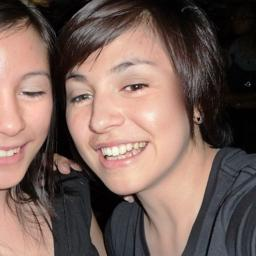

In [18]:
# View a random image
index = 12345

item = original_ds[index]
print(item['identifier'], item['label'])
item['image']

huggingfacevit/adversarial/fgsm_l1/Train/Fake/fake_11293.jpg Fake


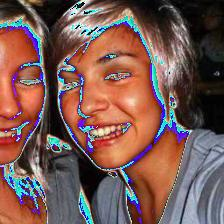

In [19]:
# View a random adversarial FGSM-L1 image
item = adversarial_l1_ds[index]
print(item['identifier'], item['label'])
item['image']

huggingfacevit/adversarial/fgsm_l2/Train/Fake/fake_11293.jpg Fake


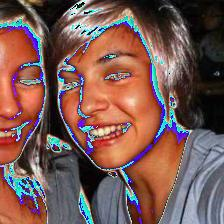

In [20]:
# View a random adversarial FGSM-L2 image
item = adversarial_l2_ds[index]
print(item['identifier'], item['label'])
item['image']

huggingfacevit/adversarial/fgsm_linf/Train/Fake/fake_11293.jpg Fake


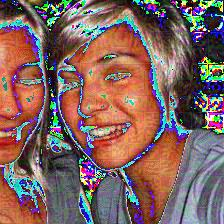

In [21]:
# View a random adversarial FGSM-L-inf image
item = adversarial_linf_ds[index]
print(item['identifier'], item['label'])
item['image']

In [22]:
# Prepare model pipeline
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
model_str = "dima806/deepfake_vs_real_image_detection"
classifier = pipeline('image-classification', model_str, device='cuda')

2024-06-22 12:43:59.905867: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 12:44:00.818505: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Evaluate original model on "clean" dataset
with open('/home/aaraborar/cs199/huggingfacevit/baseline.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    results = classifier(KeyDataset(original_ds, 'image'))
    for result, ident in tqdm(zip(results, original_ds['identifier'])):
        writer.writerow(max(({ 'label': res['label'], 'score': res['score'], 'identifier': ident } for res in result), key=itemgetter('score')))

In [43]:
base_pred_df = labels_to_enum(baseline_predictions_path)
get_accuracy(base_pred_df, 'baseline')

baseline accuracy = 0.9924396458875141, 188896.0 correct predictions out of 190335


# Sample and evaluate on original and adversarial datasets

In [24]:
base_samples_path = '/home/aaraborar/cs199/huggingfacevit/samples_original/sample'
l1_samples_path = '/home/aaraborar/cs199/huggingfacevit/samples_fgsm_l1/adv-sample'
l2_samples_path = '/home/aaraborar/cs199/huggingfacevit/samples_fgsm_l2/adv-sample'
linf_samples_path = '/home/aaraborar/cs199/huggingfacevit/samples_fgsm_linf/adv-sample'

csv_write_paths = [base_samples_path, l1_samples_path, l2_samples_path, linf_samples_path]
hf_datasets = [original_ds, adversarial_l1_ds, adversarial_l2_ds, adversarial_linf_ds]

In [31]:
# Generate 50 samples with 1000 images for each dataset
for path, ds in zip(csv_write_paths, hf_datasets):
    for i in tqdm(range(1,51)):
        sample = ds.train_test_split(test_size=1000, seed=i)['test']
        with open(f'{path}{i}.csv', 'w', newline='') as csvfile:
            fieldnames = ['label', 'score', 'identifier']
            writer = DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            results = classifier(KeyDataset(sample, 'image'))
            for result, ident in zip(results, sample['identifier']):
                writer.writerow(max(({ 'label': res['label'], 'score': res['score'], 'identifier': ident } for res in result), key=itemgetter('score')))

100%|██████████| 50/50 [05:37<00:00,  6.76s/it]


## Statistical analysis

In [25]:
# Count number of wrong predictions

def get_error_counts(path: str):
    error_counts = []
    for i in range(1,51):
        sample = pl.scan_csv(f'{path}{i}.csv').with_columns(true_labels).collect()
        isCorrect_df = (sample['label'] == sample['true label']).value_counts()
        error_counts.append(isCorrect_df.filter(pl.col('label') == pl.lit(False)).select('count').item())
    return error_counts

In [26]:
errors_dict = { 'datasets': ['baseline', 'L1', 'L2', 'L-inf'], 'error_counts': [] }

for path in csv_write_paths:
    errors_dict['error_counts'].append(get_error_counts(path))

errors = pl.from_dict(errors_dict)
errors.head()

datasets,error_counts
str,list[i64]
"""baseline""","[8, 5, … 9]"
"""L1""","[188, 198, … 204]"
"""L2""","[221, 240, … 245]"
"""L-inf""","[533, 555, … 526]"


In [30]:
error_dict_columns = {}

for i in range(errors.height):
    curr_ds = errors[i].select('datasets').item()
    curr_ds_error_counts = errors[i].select('error_counts').item()
    print(curr_ds_error_counts.describe())
    error_dict_columns[curr_ds] = curr_ds_error_counts

shape: (9, 2)
┌────────────┬─────────┐
│ statistic  ┆ value   │
│ ---        ┆ ---     │
│ str        ┆ f64     │
╞════════════╪═════════╡
│ count      ┆ 50.0    │
│ null_count ┆ 0.0     │
│ mean       ┆ 7.52    │
│ std        ┆ 2.56539 │
│ min        ┆ 4.0     │
│ 25%        ┆ 6.0     │
│ 50%        ┆ 7.0     │
│ 75%        ┆ 9.0     │
│ max        ┆ 15.0    │
└────────────┴─────────┘
shape: (9, 2)
┌────────────┬──────────┐
│ statistic  ┆ value    │
│ ---        ┆ ---      │
│ str        ┆ f64      │
╞════════════╪══════════╡
│ count      ┆ 50.0     │
│ null_count ┆ 0.0      │
│ mean       ┆ 196.48   │
│ std        ┆ 10.75182 │
│ min        ┆ 170.0    │
│ 25%        ┆ 190.0    │
│ 50%        ┆ 197.0    │
│ 75%        ┆ 202.0    │
│ max        ┆ 224.0    │
└────────────┴──────────┘
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 50.0      │
│ null_count ┆ 0.0       │
│ me

In [31]:
errors_exploded = errors.explode('error_counts')
errors_exploded.head()

datasets,error_counts
str,i64
"""baseline""",8
"""baseline""",5
"""baseline""",7
"""baseline""",8
"""baseline""",7


In [36]:
errors_exploded.plot.hist('error_counts', by='datasets', bins=100)

:NdOverlay   [datasets]
   :Histogram   [error_counts]   (Count)

In [42]:
errors_hists = pl.from_dict(error_dict_columns)
errors_hists.head()

baseline,L1,L2,L-inf
i64,i64,i64,i64
8,188,221,533
5,198,240,555
7,190,235,532
8,199,246,553
7,215,252,562


In [38]:
from scipy import stats

In [49]:
print(f"Shapiro-Wilk normality test p-val={stats.shapiro(errors_hists['baseline']).pvalue}")
errors_hists.plot.hist('baseline', bins=10)

Shapiro-Wilk normality test p-val=0.008575529348051855


:Histogram   [baseline]   (Count)

In [50]:
print(f"Shapiro-Wilk normality test p-val={stats.shapiro(errors_hists['L1']).pvalue}")
errors_hists.plot.hist('L1', bins=10)

Shapiro-Wilk normality test p-val=0.6427364403418683


:Histogram   [L1]   (Count)

In [51]:
print(f"Shapiro-Wilk normality test p-val={stats.shapiro(errors_hists['L2']).pvalue}")
errors_hists.plot.hist('L2', bins=10)

Shapiro-Wilk normality test p-val=0.5384669070707617


:Histogram   [L2]   (Count)

In [52]:
print(f"Shapiro-Wilk normality test p-val={stats.shapiro(errors_hists['L-inf']).pvalue}")
errors_hists.plot.hist('L-inf', bins=10)

Shapiro-Wilk normality test p-val=0.7245414671935608


:Histogram   [L-inf]   (Count)